In [2]:
import json
import pandas as pd
import folium
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tqdm
import ast
import time
import os
import csv 
from shapely.geometry import Point
from numpy import radians, sin, cos, arcsin, sqrt
import seaborn as sns
import branca.colormap as cm
import shutil

# 合并Review

### 读入所用bussiness的review

['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date']
总共6990280行

In [34]:
yelp_path='/data2/fanbingbing/data/Yelp/'
yelp_reviews_file_name = 'yelp_academic_dataset_review.json'
yelp_reviews_file_path = yelp_path+yelp_reviews_file_name

#json文件有多行 读取数据时要逐行阅读
all_data_temp=[]
business_id_temp=[]
with open(yelp_reviews_file_path, 'r', encoding='utf-8') as file:
    for line in file:
        try:
            data_temp = json.loads(line)
            all_data_temp.append(data_temp)
        except json.JSONDecodeError as e: #没有报错
            print(f"Error parsing JSON object on line: {file.lineno()} - {e}")
review_df = pd.DataFrame(all_data_temp)    

print(review_df.shape)
print(review_df.columns)
review_df.head(5)

(6990280, 9)
Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


### 筛选费城中review
关于费城5363个poi有491934行

In [35]:
#只保留费城这些地点的review
result_df= pd.read_csv('/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_with_yelp.csv')
filtered_review_df = review_df[review_df['business_id'].isin(result_df['business_id'])]
del review_df
filtered_review_df.sort_values(by='business_id', inplace=True)
filtered_review_df.reset_index(drop=True, inplace=True)

print(filtered_review_df.shape)
filtered_review_df.head()

(491934, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,JN5jOx0ZFxCVogc03xwFXA,NPeWmBJvrd6eObuqzd9ExQ,-0M0b-XhtFagyLmsBtOe8w,4.0,1,1,1,I like Paris. I like wine. Turns out they have...,2013-01-27 16:16:21
1,araJ6c0YDNnFx-M6Odqi9g,7V5r7JoEPmN_AugXccs6gg,-0M0b-XhtFagyLmsBtOe8w,5.0,0,0,0,My wife and I celebrated our 16th wedding anni...,2016-01-30 03:25:06
2,vKntnXD7lSzamRZ993cZ-A,TsCxKoUlhNfKY1Rt87_-Wg,-0M0b-XhtFagyLmsBtOe8w,4.0,0,0,0,I've liked London (the connected bar/restauran...,2012-02-18 15:39:10
3,MVYGAV-5kUREFRR9Kw0BcQ,exDOIbSQ2S5hSwewrs1MVw,-0M0b-XhtFagyLmsBtOe8w,3.0,1,0,1,It's a little hard to tell the difference betw...,2012-03-14 17:05:44
4,WNImBm6BR2I6U19R4jTz0g,N9hqTPQu2bmI8c2Pj8F1ww,-0M0b-XhtFagyLmsBtOe8w,4.0,7,3,5,Wine up! It's about to get real: The time has ...,2015-06-24 22:10:39


### 将review整理到result_df中

/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_with_yelp_review.csv

['placekey', 'sum_visitors', 'poi_cbg', 'distance_from_home', 'latitude',
       'longitude', 'poi_category', 'poi_tract',
       'same_category_number_in_tract', 'visitor_home_cbgs',
       'visitor_home_cbgs_income_level', 'visitor_home_cbgs_income_proportion',
       'segregation_index', 'location_name', 'business_id', 'name', 'address',
       'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours',
       'different_cbg_num', 'review', 'review_num']
       

In [0]:
# 根据business_id进行分组
grouped = filtered_review_df.groupby('business_id')

# 初始化result_df，假设它原来没有'review'列
result_df['review'] = None

# 遍历每个分组，并转换为字典列表
for business_id, group in tqdm.tqdm(grouped):
    # 找到result_df中对应的行
    corresponding_rows = result_df[result_df['business_id'] == business_id]
    if not corresponding_rows.empty:
        # 将filtered_review_df中的行转换为字典列表
        review_list = []
        for index, row in group.iterrows():
            review_dict = {
                'stars': row['stars'],
                'useful': row['useful'],
                'funny': row['funny'],
                'cool': row['cool'],
                'text': row['text'],
                'date': row['date']
            }
            review_list.append(review_dict)
        for index, row in corresponding_rows.iterrows():
            result_df.at[index, 'review'] = review_list 
            #这样就可以把列表赋给某行某列了

In [34]:
result_df=pd.read_csv('/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_with_yelp_review.csv')

#因为review是Str形式，所以不能直接len，要先转化为list
print(type(result_df.loc[0,'review'])) #str
result_df['review'] = result_df['review'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
print(type(result_df.loc[0,'review'])) #list

result_df['review_num']=result_df['review'].apply(lambda x:len(x))
result_df.to_csv('/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_with_yelp_review.csv',index=False)
result_df.head()

KeyboardInterrupt: 

In [10]:
#case study
result_df=pd.read_csv('/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_with_yelp_review.csv')

result_df.sort_values(by='segregation_index',ascending=False, inplace=True)
result_df.iloc[10]
print(result_df.iloc[10,24])
result_df.loc[2450,'visitor_home_cbgs_income_proportion']

# 合并images

### 读入所有photos
images_df  所有200100张
['photo_id', 'business_id', 'caption', 'label']

In [43]:
yelp_path='/data2/fanbingbing/data/Yelp/'
yelp_images_file_name = 'photos.json'
yelp_images_file_path = yelp_path+yelp_images_file_name

#json文件有多行 读取数据时要逐行阅读
all_data_temp=[]
business_id_temp=[]
with open(yelp_images_file_path, 'r', encoding='utf-8') as file:
    for line in file:
        try:
            data_temp = json.loads(line)
            all_data_temp.append(data_temp)
        except json.JSONDecodeError as e: #没有报错
            print(f"Error parsing JSON object on line: {file.lineno()} - {e}")
images_df = pd.DataFrame(all_data_temp)    

print(images_df.shape)
print(images_df.columns)
images_df.head(5)

(200100, 4)
Index(['photo_id', 'business_id', 'caption', 'label'], dtype='object')


,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


### 保留费城地点photos
15156张

In [44]:
#只保留费城这些地点的images
result_df= pd.read_csv('/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_with_yelp_review.csv')
filtered_images_df = images_df[images_df['business_id'].isin(result_df['business_id'])]
del images_df
filtered_images_df.sort_values(by='business_id', inplace=True)
filtered_images_df.reset_index(drop=True, inplace=True)

print(filtered_images_df.shape)
filtered_images_df.head()

(15156, 4)


,photo_id,business_id,caption,label
0,1brLBjW5JznRUNdX7FItvQ,-0M0b-XhtFagyLmsBtOe8w,"Art Fischman plays Thursdays, photo by Julia B...",inside
1,Nroz-phrBw1-TjaWIRBbMA,-0eUa8TsXFFy0FCxHYmrjg,,food
2,vM4ODEHIHWOdHYEptcjK0g,-2-ih3mE8KPyeKVIzpBfPQ,,inside
3,YWN5IUK_1dPf4Mog5gqpkQ,-2-ih3mE8KPyeKVIzpBfPQ,,inside
4,E181gjUSI3oBzdo7LZemqg,-2-ih3mE8KPyeKVIzpBfPQ,,outside


### 将photos合并到result_df中
/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_with_yelp_review_images.csv

['placekey', 'sum_visitors', 'poi_cbg', 'distance_from_home', 'latitude',
       'longitude', 'poi_category', 'poi_tract',
       'same_category_number_in_tract', 'visitor_home_cbgs',
       'visitor_home_cbgs_income_level', 'visitor_home_cbgs_income_proportion',
       'segregation_index', 'location_name', 'business_id', 'name', 'address',
       'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours',
       'different_cbg_num', 'review', 'review_num', 'images', 'iamges_num']
      


In [46]:
#iamges合并到poi信息+review中

# 根据business_id进行分组
grouped = filtered_images_df.groupby('business_id')
result_df['images'] = None

# 遍历每个分组，并转换为字典列表
for business_id, group in tqdm.tqdm(grouped):
    # 找到result_df中对应的行
    corresponding_rows = result_df[result_df['business_id'] == business_id]
    if not corresponding_rows.empty:
        # 将filtered_images_df中的行转换为字典列表
        images_list = []
        for index, row in group.iterrows():
            images_dict = {
                'photo_id': row['photo_id'],
                'caption': row['caption'],
                'label': row['label']
            }
            images_list.append(images_dict)
        for index, row in corresponding_rows.iterrows():
            result_df.at[index, 'images'] = images_list 
            #这样就可以把列表赋给某行某列了

result_df['images_num']=result_df['images'].apply(lambda x:len(x) if x is not None else 0)

print(result_df.columns)
print(result_df.shape)
result_df.to_csv('/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_with_yelp_review_images.csv',index=False)

result_df.head()

# review_num和images_num大小简单分析


In [99]:
result_df=pd.read_csv('/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_with_yelp_review_images.csv',usecols=['review_num','images_num'])

# 设置筛选阈值
review_threshold = 250
images_threshold = 10
# 筛选掉review_num中的离群值
filtered_review_df = result_df[result_df['review_num'] <= review_threshold]
# 筛选掉images_num中的离群值
filtered_images_df = result_df[result_df['images_num'] <= images_threshold]

In [95]:
#观察特别大的值情况
num_result = result_df['review_num'].value_counts().sort_index()
print(num_result[:-36:-1].sum())
print(num_result[num_result.index>250].sum())
print(result_df['review_num'].quantile(0.75))

num2_result = result_df['images_num'].value_counts().sort_index()
print(num2_result[:-42:-1].sum())
print(num2_result[num2_result.index>20].sum())
print(result_df['images_num'].quantile(0.75))

36
478
84.0


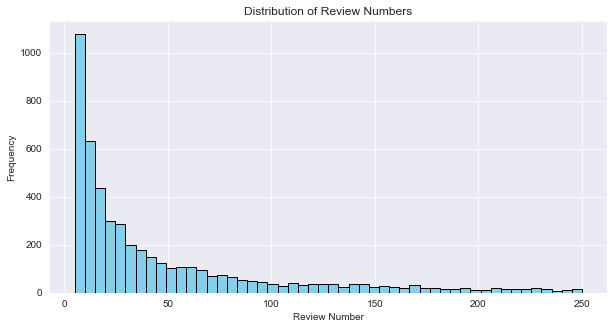

In [100]:
# 绘制review_num列的直方图
plt.figure(figsize=(10, 5))  # 设置图形的大小
filtered_review_df['review_num'].hist(bins=50, color='skyblue', edgecolor='black')  # 绘制直方图，bins是直方图的箱数
plt.title('Distribution of Review Numbers')  # 设置图形的标题
plt.xlabel('Review Number')  # 设置x轴的标签
plt.ylabel('Frequency')  # 设置y轴的标签
plt.grid(True)  # 显示网格线
plt.show()  # 显示图形

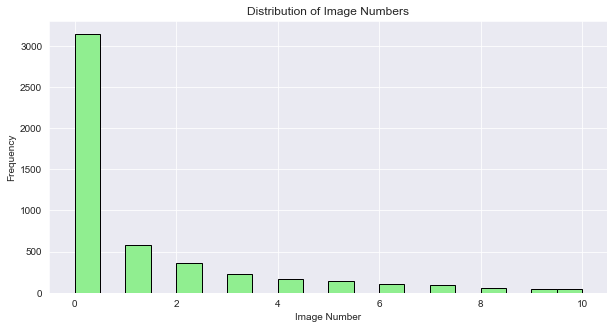

In [102]:
# 绘制images_num列的直方图
plt.figure(figsize=(10, 5))  # 设置图形的大小
filtered_images_df['images_num'].hist(bins=20, color='lightgreen', edgecolor='black')  # 绘制直方图
plt.title('Distribution of Image Numbers')  # 设置图形的标题
plt.xlabel('Image Number')  # 设置x轴的标签
plt.ylabel('Frequency')  # 设置y轴的标签
plt.grid(True)  # 显示网格线
plt.show()  # 显示图形

# 整理images数据集好调用

### 逐一读取
保存方式：/data2/fanbingbing/data/Yelp/Philadelphia_images/'placekey'_0,1,2,....jpg

In [10]:
result_df=pd.read_csv('/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_with_yelp_review_images.csv',usecols=['placekey','images','images_num'])
result_df.head()

,placekey,images,images_num
0,222-222@628-p6z-b8v,NaN,0
1,222-222@628-p74-wtv,"[{'photo_id': 'ITmgGugNqCv7qv8cexFLsQ', 'capti...",5
2,222-222@628-p77-2hq,NaN,0
3,222-222@628-p7b-hnq,NaN,0
4,222-222@628-p7b-rc5,NaN,0


In [11]:
# 遍历DataFrame中的每一行
for index, row in result_df.iterrows():
    # 检查images列是否为NaN，如果不是NaN，则继续处理
    if not pd.isna(row['images']):
        placekey_value = row['placekey']
        # 使用ast.literal_eval将images列的字符串转换为列表
        images_list = ast.literal_eval(row['images'])
        
        # 遍历images_list中的每个元素（字典）
        for i, image_dict in enumerate(images_list):
            # 从字典中取出photo_id
            photo_id = image_dict.get('photo_id')
            if photo_id:
                # 定义原始图片的路径
                original_photo_path = f'/data2/fanbingbing/data/Yelp/photos/{photo_id}.jpg'
                # 检查原始图片是否存在
                if os.path.exists(original_photo_path):
                    # 定义新图片的保存路径和文件名
                    new_photo_path = f'/data2/fanbingbing/data/Yelp/Philadelphia_images/{placekey_value}_{i}.jpg'
                    # 确保保存路径的文件夹存在
                    os.makedirs(os.path.dirname(new_photo_path), exist_ok=True)
                    # 将图片复制到新的路径，并重命名
                    shutil.copyfile(original_photo_path, new_photo_path)
                else:
                    print(f'File not found: {original_photo_path}')
            else:
                print(f'Photo ID not found in image dict at index {index}')
    else:
        # 如果images列为NaN，则跳过
        continue

In [13]:
#验证是否正确
print(result_df['images_num'].sum())

# 使用os.listdir()列出文件夹中的所有项（包括文件和子文件夹）
all_items = os.listdir('/data2/fanbingbing/data/Yelp/Philadelphia_images/')
# 过滤掉子文件夹，只计算文件
files = [item for item in all_items if os.path.isfile(os.path.join('/data2/fanbingbing/data/Yelp/Philadelphia_images/', item))]
print(f"There are {len(files)} files in the directory.")

15156
There are 15156 files in the directory.


#  合并imagetext


### 逐一读取text image文件合并到一起

In [14]:
import csv
# file_template = '/data2/fanbingbing/data/segregation/philadelphia/temp_image2text/GPT4v/text_result_{}.csv' #GPT4v的
file_template = '/data2/fanbingbing/LLaVA/llavatextdata/text_result_{}.csv' #LLaVA的
all_text_results = []
for i in range(11):  # 从0到10，共11个文件
    print(i)
    file_path = file_template.format(i)  # 格式化文件路径
    with open(file_path, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.reader(file)  # 使用csv.reader来读取文件
        text_result = list(reader)  # 读取CSV文件的每一行，并将这些行存储到一个列表中
        # 对列表中的每个字符串进行处理，移除前后的特定字符
    all_text_results.extend(text_result)  # 将当前文件的列表追加到总列表中

df_temp = pd.DataFrame(all_text_results)

# 显示结果
print(df_temp.shape) #5363*201
df_temp.head()

0
1
2
3
4
5
6
7
8
9
10
(5363, 201)


,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,artoftext|> The image shows a breakfast sandwi...,artoftext|> The image shows a Dunkin' branded ...,artoftext|> The image shows a classic Dunkin' ...,artoftext|> The image shows a Dunkin' branded ...,artoftext|> The image shows a close-up of a ba...,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [15]:
# llava的不干净，进行处理
# 移除 'artoftext|>' 和 '<|im_e' 的函数
def clean_text(text):
    if isinstance(text, str):  # 检查是否为字符串类型
        return text.replace('artoftext|>', '').replace('<|im_e', '')
    return text

# 使用 applymap 方法将 clean_text 函数应用到 df_temp 的每个单元格
df_temp = df_temp.applymap(clean_text)

df_temp.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,The image shows a breakfast sandwich with a g...,The image shows a Dunkin' branded coffee cup ...,The image shows a classic Dunkin' experience ...,The image shows a Dunkin' branded setting wit...,The image shows a close-up of a bagel with cr...,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


### 拼成result_df中的一列

In [16]:
import pandas as pd
result_df=pd.read_csv('/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_with_yelp_review_images.csv')
result_df.head()

,placekey,sum_visitors,poi_cbg,distance_from_home,latitude,longitude,poi_category,poi_tract,same_category_number_in_tract,visitor_home_cbgs,...,review_count,is_open,attributes,categories,hours,different_cbg_num,review,review_num,images,images_num
0,222-222@628-p6z-b8v,11994.650695,421010351001,7150.500000,40.045721,-74.994275,Restaurants,4.210104e+10,5.0,"{'421010362023': 128.80225400678628, '42101033...",...,17,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsTab...","Bars, Restaurants, Sports Bars, Pubs, Sandwich...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-0:0', '...",59,"[{'stars': 5.0, 'useful': 0, 'funny': 0, 'cool...",17,NaN,0
1,222-222@628-p74-wtv,62957.124151,421010331012,1506.583333,40.038745,-75.036203,Bars and Drinking Places,4.210103e+10,5.0,"{'421010331011': 3727.1850262015905, '42101033...",...,17,1,"{'WiFi': ""'free'"", 'RestaurantsTakeOut': 'True...","Food, Restaurants, Donuts, Coffee & Tea","{'Monday': '4:30-0:0', 'Tuesday': '4:30-0:0', ...",206,"[{'stars': 4.0, 'useful': 1, 'funny': 1, 'cool...",18,"[{'photo_id': 'ITmgGugNqCv7qv8cexFLsQ', 'capti...",5
2,222-222@628-p77-2hq,6168.608214,421019891001,12798.583333,40.036244,-75.004551,"Arts, Cultural and Amussement Places",4.210199e+10,4.0,"{'421010330006': 304.59537822175304, '42101033...",...,10,1,"{'GoodForKids': 'True', 'BikeParking': 'True',...","Gun/Rifle Ranges, Active Life","{'Monday': '7:0-22:0', 'Tuesday': '15:0-22:0',...",36,"[{'stars': 4.0, 'useful': 7, 'funny': 2, 'cool...",10,NaN,0
3,222-222@628-p7b-hnq,8987.587392,421010348023,3540.166667,40.056903,-75.013343,Personal Services,4.210103e+10,2.0,"{'421010348013': 582.0269057934444, '421010381...",...,13,1,NaN,"Automotive, Wheel & Rim Repair, Tires, Auto Re...","{'Monday': '9:0-17:30', 'Tuesday': '9:0-17:30'...",70,"[{'stars': 5.0, 'useful': 1, 'funny': 0, 'cool...",14,NaN,0
4,222-222@628-p7b-rc5,4624.204464,421010346001,13408.250000,40.069881,-75.017379,Stores,4.210103e+10,28.0,"{'421010383002': 166.61251787160418, '42101026...",...,11,1,"{'GoodForKids': 'True', 'BusinessAcceptsCredit...","Martial Arts, Sporting Goods, Fashion, Sports ...","{'Monday': '9:30-17:30', 'Tuesday': '9:30-17:3...",31,"[{'stars': 1.0, 'useful': 0, 'funny': 0, 'cool...",13,NaN,0


In [17]:
import numpy as np
import ast
# 遍历 result_df 中的每一行
def updataimagetext(row):
    # 取出 df_temp 的对应行
    df_temp_row = df_temp.iloc[row.name]
    
    # 判断 images_num 与 df_temp 对应行非 None 列的个数是否一致 都对
    if row['images_num'] != df_temp_row.notnull().sum():
        print(f"第 {row.name} 行出错")  # 输出错误信息
        return 'wrong'  # 继续下一次循环
        
    if row['images_num']>0:  
        # print('yes in if')
        images_list = ast.literal_eval(row['images'])#字符串转化为列表
        
        # 将字典元素 photo_id 替换为 image_text
        updated_images_list = []
        for j, image_info in enumerate(images_list):
            del image_info['photo_id']
            # 确保 df_temp 当前列不是 None
            if pd.notnull(df_temp_row.iloc[j]):
                image_info['image_text'] = str(df_temp_row.iloc[j])  # 将图片描述转换为字符串并赋值
                updated_images_list.append(image_info) 
        return updated_images_list
        # result_df.at[i,'images_text'] = json.dumps(updated_images_list)
    else:
        # print('yes in else')
        return np.NaN 


result_df['images_text'] = result_df.apply(updataimagetext,axis=1)

result_df.head()

,placekey,sum_visitors,poi_cbg,distance_from_home,latitude,longitude,poi_category,poi_tract,same_category_number_in_tract,visitor_home_cbgs,...,is_open,attributes,categories,hours,different_cbg_num,review,review_num,images,images_num,images_text
0,222-222@628-p6z-b8v,11994.650695,421010351001,7150.500000,40.045721,-74.994275,Restaurants,4.210104e+10,5.0,"{'421010362023': 128.80225400678628, '42101033...",...,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsTab...","Bars, Restaurants, Sports Bars, Pubs, Sandwich...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-0:0', '...",59,"[{'stars': 5.0, 'useful': 0, 'funny': 0, 'cool...",17,NaN,0,NaN
1,222-222@628-p74-wtv,62957.124151,421010331012,1506.583333,40.038745,-75.036203,Bars and Drinking Places,4.210103e+10,5.0,"{'421010331011': 3727.1850262015905, '42101033...",...,1,"{'WiFi': ""'free'"", 'RestaurantsTakeOut': 'True...","Food, Restaurants, Donuts, Coffee & Tea","{'Monday': '4:30-0:0', 'Tuesday': '4:30-0:0', ...",206,"[{'stars': 4.0, 'useful': 1, 'funny': 1, 'cool...",18,"[{'photo_id': 'ITmgGugNqCv7qv8cexFLsQ', 'capti...",5,"[{'caption': '', 'label': 'food', 'image_text'..."
2,222-222@628-p77-2hq,6168.608214,421019891001,12798.583333,40.036244,-75.004551,"Arts, Cultural and Amussement Places",4.210199e+10,4.0,"{'421010330006': 304.59537822175304, '42101033...",...,1,"{'GoodForKids': 'True', 'BikeParking': 'True',...","Gun/Rifle Ranges, Active Life","{'Monday': '7:0-22:0', 'Tuesday': '15:0-22:0',...",36,"[{'stars': 4.0, 'useful': 7, 'funny': 2, 'cool...",10,NaN,0,NaN
3,222-222@628-p7b-hnq,8987.587392,421010348023,3540.166667,40.056903,-75.013343,Personal Services,4.210103e+10,2.0,"{'421010348013': 582.0269057934444, '421010381...",...,1,NaN,"Automotive, Wheel & Rim Repair, Tires, Auto Re...","{'Monday': '9:0-17:30', 'Tuesday': '9:0-17:30'...",70,"[{'stars': 5.0, 'useful': 1, 'funny': 0, 'cool...",14,NaN,0,NaN
4,222-222@628-p7b-rc5,4624.204464,421010346001,13408.250000,40.069881,-75.017379,Stores,4.210103e+10,28.0,"{'421010383002': 166.61251787160418, '42101026...",...,1,"{'GoodForKids': 'True', 'BusinessAcceptsCredit...","Martial Arts, Sporting Goods, Fashion, Sports ...","{'Monday': '9:30-17:30', 'Tuesday': '9:30-17:3...",31,"[{'stars': 1.0, 'useful': 0, 'funny': 0, 'cool...",13,NaN,0,NaN


In [18]:
# result_df.to_csv('/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_with_yelp_review_image_imagestext_GPT4v.csv',index=False)
result_df.to_csv('/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_with_yelp_review_image_imagestext_LLaVA.csv',index=False)

In [19]:
#随机验证顺序
print(result_df.loc[3420,'name'])
print(result_df.loc[3420,'images_text'])

Pietro's Coal Oven Pizzeria
[{'caption': 'I sat in the third table on the right', 'label': 'inside', 'image_text': " The image shows the interior of Pietro's Coal Oven Pizzeria, a restaurant specializing in Italian cuisine, particularly pizza. The space is characterized by a rustic ambiance with exposed brick walls and wooden floors. The seating arrangement includes tables with white tablecloths and chairs, some of which are occupied by patrons. The lighting is warm and subdued, contributing to the cozy atmosphere. In the background, there are visible elements of the kitchen, including what appears to be a pizza oven, suggesting the restaurant's focus on traditional cooking methods. The overall impression is of a comfortable and inviting dining environment."}, {'caption': '', 'label': 'inside', 'image_text': " The image depicts an interior view of a dining area at Pietro's Coal Oven Pizzeria. The room is adorned with colorful balloons, suggesting a festive occasion or celebration. A lo

# 替换总结的POIresult

### 逐一读取text image文件合并到一起

In [10]:
import os
import pandas as pd

file_path = '/data2/fanbingbing/GPTdatasets/summary_result/' 

df_temp = pd.DataFrame()

# 遍历指定路径下的所有文件
for filename in os.listdir(file_path):
    # 检查文件扩展名是否为.csv
    if filename.endswith('.csv'):
        # 构建完整的文件路径
        file_full_path = os.path.join(file_path, filename)
        # 打印文件名
        print(f"正在处理文件: {filename}")
        # 读取当前文件到DataFrame中
        df_file = pd.read_csv(file_full_path)
        # 将当前文件的DataFrame追加到df_temp中
        df_temp = pd.concat([df_temp, df_file], ignore_index=True)
df_temp.rename(columns={'plackey':'placekey'},inplace=True)
print(df_temp.shape)  #5363*2
df_temp.head()

正在处理文件: summary_result_20_1714291090.0059829.csv
正在处理文件: summary_result_17_1714287124.2055798.csv
正在处理文件: summary_result_22_1714293707.8869877.csv
正在处理文件: summary_result_16_1714285655.8183956.csv
正在处理文件: summary_result_18_1714288564.354955.csv
正在处理文件: summary_result_9_1714275237.8718815.csv
正在处理文件: summary_result_12_1714279422.0082743.csv
正在处理文件: summary_result_25_1714304563.2352023.csv
正在处理文件: summary_result_19_1714289920.9167871.csv
正在处理文件: summary_result_14_1714282305.5461097.csv
正在处理文件: summary_result_23_1714295040.9804995.csv
正在处理文件: summary_result_1_1714238256.610843.csv
正在处理文件: summary_result_0_1714236872.8261294.csv
正在处理文件: summary_result_7_1714272269.018765.csv
正在处理文件: summary_result_8_1714273688.5301113.csv
正在处理文件: summary_result_6_1714244950.6067278.csv
正在处理文件: summary_result_3_1714241123.836156.csv
正在处理文件: summary_result_15_1714283562.2086544.csv
正在处理文件: summary_result_24_1714296723.0559204.csv
正在处理文件: summary_result_5_1714243662.2413783.csv
正在处理文件: summary_result_10_171427

,placekey,POI summary
0,25j-222@628-pm4-7t9,Summary: K & A Sandwiches & Grocery is a highl...
1,25j-222@628-pm4-skf,"Summary: Khmer Kitchen is a small, family-owne..."
2,25j-222@628-pmb-c3q,Summary:\nBlendo is a unique Point of Interest...
3,25j-223@628-pm4-skf,Summary: Maliwan is a highly regarded Point of...
4,25j-224@628-pm4-skf,"Summary: Cafe Ayla is a small, family-owned Th..."


### 拼成最原始result_df中的一列

In [11]:
import pandas as pd

result_df = pd.read_csv('/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_with_yelp.csv')#.iloc[:5,:] #只需要读取没有review和images的

result_df = result_df.merge(df_temp,on='placekey',how='left')
print(result_df.columns)
result_df.shape

Index(['placekey', 'sum_visitors', 'poi_cbg', 'distance_from_home', 'latitude',
       'longitude', 'poi_category', 'poi_tract',
       'same_category_number_in_tract', 'visitor_home_cbgs',
       'visitor_home_cbgs_income_level', 'visitor_home_cbgs_income_proportion',
       'segregation_index', 'location_name', 'business_id', 'name', 'address',
       'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours',
       'different_cbg_num', 'POI summary'],
      dtype='object')


(5369, 25)

In [12]:
result_df.to_csv(
    '/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_with_yelp_summary_GPT4v.csv',
    index=False)

In [15]:
#随机验证顺序
print(result_df.loc[2200, :])
# print(result_df.loc[2200, 'POI summary'])

placekey                                                             22m-222@628-pmf-ht9
sum_visitors                                                                     42448.7
poi_cbg                                                                     421010004022
distance_from_home                                                                 15157
latitude                                                                         39.9529
longitude                                                                       -75.1709
poi_category                                        Arts, Cultural and Amussement Places
poi_tract                                                                     4.2101e+10
same_category_number_in_tract                                                         24
visitor_home_cbgs                      {'421010245001': 226.05054217255258, '42101001...
visitor_home_cbgs_income_level         {'421010245001': 0.0, '421010013001': 3.0, '42...
visitor_home_cbgs_inc

# 合并标记的POI分析，作数据集用

In [3]:
import os
import pandas as pd

file_path = '/data2/fanbingbing/GPTdatasets/generate_datasets_gpt4-32k_final/'

df_temp = pd.DataFrame()

# 遍历指定路径下的所有文件
for filename in os.listdir(file_path):
    # 检查文件扩展名是否为.csv
    if filename.endswith('.csv'):
        # 构建完整的文件路径
        file_full_path = os.path.join(file_path, filename)
        # 打印文件名
        print(f"正在处理文件: {filename}")
        # 读取当前文件到DataFrame中
        df_file = pd.read_csv(file_full_path)
        # 将当前文件的DataFrame追加到df_temp中
        df_temp = pd.concat([df_temp, df_file], ignore_index=True)
df_temp.rename(columns={'plackey':'placekey'},inplace=True)
print(df_temp.shape)  #977*2
df_temp.head()

正在处理文件: generate_result_10.csv
正在处理文件: generate_result_1.csv
正在处理文件: generate_result_9.csv
正在处理文件: generate_result_0.csv
正在处理文件: generate_result_14.csv
正在处理文件: generate_result_16.csv
正在处理文件: generate_result_13.csv
正在处理文件: generate_result_12.csv
正在处理文件: generate_result_19.csv
正在处理文件: generate_result_4.csv
正在处理文件: generate_result_5.csv
正在处理文件: generate_result_7.csv
正在处理文件: generate_result_2.csv
正在处理文件: generate_result_8.csv
正在处理文件: generate_result_18.csv
正在处理文件: generate_result_15.csv
正在处理文件: generate_result_17.csv
正在处理文件: generate_result_3.csv
正在处理文件: generate_result_11.csv
正在处理文件: generate_result_6.csv
(977, 2)


,placekey,datasets_reasoning
0,22w-222@628-pj9-6tv,### Step 1: Summarizing Characteristics of CBG...
1,22w-222@628-pmb-bx5,1. Integrating the data from the CBG features ...
2,22w-222@628-pmb-c89,**Step 1: Summary of common characteristics am...
3,22w-222@63s-dvr-9zz,**Step 1: Common Characteristics of CBGs with ...
4,22w-223@628-pfx-kmk,"Based on the provided data and analysis, we ob..."


In [4]:
result_df =pd.read_csv(
    '/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_with_yelp_summary_GPT4v.csv')
result_df = result_df.merge(df_temp,on='placekey',how='right')
print(result_df.columns)
result_df.shape

Index(['placekey', 'sum_visitors', 'poi_cbg', 'distance_from_home', 'latitude',
       'longitude', 'poi_category', 'poi_tract',
       'same_category_number_in_tract', 'visitor_home_cbgs',
       'visitor_home_cbgs_income_level', 'visitor_home_cbgs_income_proportion',
       'segregation_index', 'location_name', 'business_id', 'name', 'address',
       'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours',
       'different_cbg_num', 'POI summary', 'datasets_reasoning'],
      dtype='object')


(977, 26)

In [5]:
result_df.to_csv(
    '/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_with_yelp_GPT4v_marked_datasets.csv',
    index=False)

# 如果质量不好再加'/data2/fanbingbing/GPTdatasets/generate_datasets_gpt4-32k/'

# 一些草稿

In [7]:
import pandas as pd

result_df=pd.read_csv('/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_with_yelp_review_images.csv',usecols=['images_num']).iloc[2951:3000,:]
# selected_row=result_df[result_df['placekey']=='22b-222@628-pmf-jy9']
print(result_df['images_num'].sum())

123
